# Support Vector Machine - Solutions

In this tutorial we will be working with tweet. 

We will try to predict the sentiment of the tweets with respect to Covid-19 times using Support Vector Machines. For this task, we re-cap the exercises
* pre-processing of the corpus,
* create a bag of words model,
* train the Method, i.e., Support Vector Machines.

Finally, we will 
* test the Support Vector Machine.

## Packages

In [1]:
InstallPackages = False
if InstallPackages:
    !pip install pandas
    !pip install numpy
    !pip install scikit-learn
    !pip install spacy
    !pip install seaborn
    !pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import spacy
import matplotlib.pyplot as plt

In [3]:
from nltk import ngrams
from nltk.corpus import stopwords

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay

In [5]:
DownloadAdditions = False
if DownloadAdditions:
    nltk.download('stopwords')
    spacy.cli.download('en_core_web_sm')#de_core_news_sm #de_core_news_md

In [6]:
nlp = spacy.load('en_core_web_sm')

## Seed

In [7]:
seed = 42

## Read the Data
Read in the pre-processed 08.1 corona tweets.csv file and set it to a data frame called df.

In [8]:
df = pd.read_csv('Data/08.1 corona tweets.csv',encoding="latin1")

Use info on df

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Check the head of ad_data

In [10]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Exercise 1 - Drop ir-relevant features and convert Sentiment to dummy

**Note:** Ir-relevant features are "UserName","ScreenName","Location" and "TweetAt"

**Note:** The Label dummy should be 1 if the sentiment is Neutral, 2 if it is Positive or Extremly Positive and 0 otherwise

In [11]:
#define ir-relevant features
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]

In [12]:
#drop ir-relevant features
df.drop(unrelevant_features,inplace=True,axis=1)

In [13]:
#define dummy
class_list = []

for i in range(0, len(df)):
    value = df.loc[i, "Sentiment"]
    if value == "Neutral":
        class_list.append(1)
    elif value == "Positive" or value == "Extremely Positive":
        class_list.append(2)
    else:
        class_list.append(0)

df.loc[:,"Label"] = class_list

In [14]:
df.head()

,OriginalTweet,Sentiment,Label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1
1,advice Talk to your neighbours family to excha...,Positive,2
2,Coronavirus Australia: Woolworths to give elde...,Positive,2
3,My food stock is not the only one which is emp...,Positive,2
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


## Exercise 2 - Pre-process the tweets

*Hint:* Have a look at the previous tutorials

In [15]:
#lemmatize function
def lemmatize(statement):
    
    """
    This function is used to lemmatize the corpus. 
    
    """
    
    #define strings which should not be lemmatized
    donotlemmatize = {}#{'A','B'}
    
    #process the corpus using spaCy
    doc = nlp(statement)
    
    #lemmatize the corpus
    lemmas = [token.text.lower() if token.text in donotlemmatize else token.lemma_.lower() for token in doc]
    
    return lemmas
    

In [16]:
#pre-processing function
def preprocess(docs):
    
    """
    This function is used to preprocess the corpus: remove special characters, lemmatize, remove stopwords and correction.
    
    """
        
    #define strings which should not be stopwords
    nostopwords = {''}#{'A', 'B','a', 'b','X', 'Y','x','y'}
    
    #create list of stop words
    stop_words = list(set(stopwords.words('english'))-nostopwords)
    
    #remove special characters which are not german umlaute
    docs = docs.apply(lambda x: "".join(re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', ' ', x)))
    
    #lemmatize strings
    docs = docs.apply(lambda x: " ".join(lemmatize(x)))
    
    #remove stopwords
    docs = docs.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))

    
    return docs

In [17]:
#Now it's time to pre-process the tweets
df['document'] = preprocess(df['OriginalTweet'].astype(str))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
 2   Label          41157 non-null  int64 
 3   document       41157 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [19]:
df.head()

,OriginalTweet,Sentiment,Label,document
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,menyrbie phil gahan chrisitv https //t co / if...
1,advice Talk to your neighbours family to excha...,Positive,2,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,2,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,Positive,2,food stock one empty please panic enough food ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,ready go supermarket covid19 outbreak paranoid...


## Exercise 3 - Create a Bag of Words Model of the documents

*Hint:* Use the Count Vectorizer Function

In [20]:
#Vectorizer
vectorizer = CountVectorizer(max_features=10000)

In [21]:
#Create the bag of words model
bow = vectorizer.fit_transform(df['document'])

## Exercise 4 - Split the data into a test and a train part for x and y, respectively.

*Hint:* Use the sklearn

In [22]:
x_train,x_test,y_train,y_test = train_test_split(bow,np.asarray(df["Label"]))

In [23]:
print(x_train.shape)

(30867, 10000)


In [24]:
print(x_test.shape)

(10290, 10000)


In [25]:
print(y_train.shape)

(30867,)


In [26]:
print(y_test.shape)

(10290,)


## Exercise 5 - Conduct the *linear kernel* Support Vector Machine and look at the accuracy as well as the confusion matrix

Everything is ready, now ve can fit our classifier.

In [27]:
#model
model = SVC(kernel='linear')

In [28]:
#build the linear support vector machine
model.fit(x_train,y_train)

SVC(kernel='linear')

In [29]:
#get the predictions
predictions = model.predict(x_test)

Now, it's to see the results

In [30]:
#return the fraction of correctly classified samples of the model
print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 79.18367346938776%


In [31]:
#Build the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=model.classes_)

In [32]:
#display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

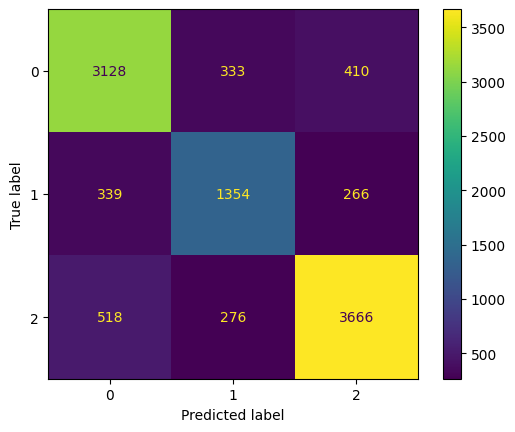

In [33]:
#plot the confusion matrix
disp.plot()

## Exercise 6 - Conduct the *Radial Basis Function kernel* Support Vector Machine and look at the accuracy as well as the confusion matrix

Everything is ready, now ve can fit our classifier.

In [34]:
#model
model = SVC(kernel='rbf')

In [35]:
#build the linear support vector machine
model.fit(x_train,y_train)

SVC()

In [36]:
#get the predictions
predictions = model.predict(x_test)

Now, it's to see the results

In [37]:
#return the fraction of correctly classified samples of the model
print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 77.01652089407192%


In [38]:
#Build the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=model.classes_)

In [39]:
#display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

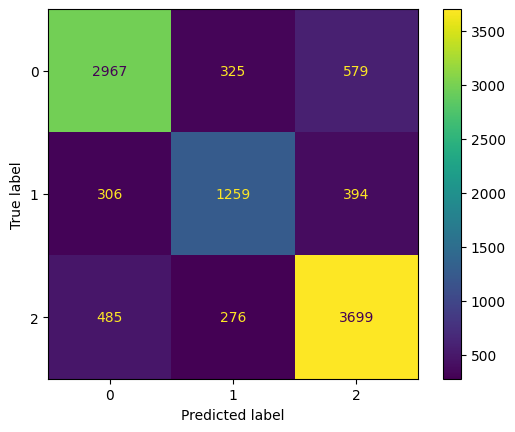

In [40]:
#plot the confusion matrix
disp.plot()